In [1]:
# Google Colab ile temel bilgilere aşina değilseniz bakınız:
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Reinforcement Learning (DQN) Tutorial

Bu öğretici, Derin Q Öğrenme (DQN) aracısını eğitmek için PyTorch'un nasıl kullanılacağını gösterir.
CartPole-v1 oyunu için: [Gymnasium](https://www.gymnasium.farama.org).

**Görev**

Temsilci iki eylem arasında karar vermelidir,Oyun şu şekilde olmalıdır. Direk dik dursun diye kendisini sağa ya da sola hareket ettirmelidir. Daha fazla çevre ve ortamlar hakkında bilgi için [Gymnasium's website](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

Genel mantık şöyledir:
Ajan ortamın mevcut durumunu gözlemledikçe ve bir eylemi seçtikten sonra, ortam yeni bir duruma *geçiş yapar* ve ayrıca
eylemin sonuçlarını gösteren bir ödül döndürür. Bunda
görev, ödüller her artımlı zaman adımı ve ortam için +1'dir.
Direk çok uzağa düşerse veya araba 2,4'ten fazla hareket ederse
merkezden uzak birimler sona erer. Bu, daha iyi performans gösteren senaryoların çalışacağı anlamına gelir.

CartPole görevinde, aracıya girişler 4 gerçek değer olacak şekilde tasarlanmıştır.
Bunlar ortam durumunu temsil eden değerlerlerdir.
Bu 4 girişi herhangi bir ölçekleme yapmadan alıp bir programdan geçiriyoruz.
Her eylem için bir tane olmak üzere 2 çıkışlı küçük tam bağlantılı ağ kullanacağız.Ağa giriş durum verildikten sonra, her eylem için beklenen değeri tahmin edecek şekilde eğitilir.Dolayısıyla beklenen değeri en yüksek olan eylem
seçilir.

**Paketler**


Öncelikle gerekli paketleri import edelim.
[gymnasium](https://gymnasium.farama.org/)


In [ ]:
%%bash
pip3 install gymnasium[classic_control]

PyTorch'tan aşağıdakileri de kullanacağız:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# matplotlib için
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# eğer gpu kullanıyorsak
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory - Tekrar Belleği

DQN'mizi eğitmek için deneyim dediğimiz tekrar belleğini kullanacağız. Bu bellek aracının gözlemlediği geçişler depolar, bu verileri yeniden kullanmamıza izin verir.
Daha sonra rastgele örnekleme yaparak, bir yapı oluşturan geçişler
parti ilişkisizdir. Bunun büyük ölçüde stabilize olduğu gösterilmiştir.
ve DQN eğitim prosedürünü geliştirir.

Bunun için iki sınıfa ihtiyacımız olacak:

-  ``Transition`` - Tek bir geçişi temsil eden adlandırılmış bir demet
çevremiz. Temelde (durum, eylem) çiftlerini eşler
(sonraki_durum, ödül) sonucuna göre
-  ``ReplayMemory`` - 
Son zamanlarda gözlemlenen geçişleri tutan sınırlı boyutta döngüsel bir arabellektir. Ayrıca bir ``.sample()`` metodu uygular. Bu metod eğitim için rastgele bir geçiş partisi seçme yöntemidir..




In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Bir geçişi kaydet"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Şimdi modelimizi tanımlayalım. Ama önce, DQN'nin ne olduğunu hızlı bir şekilde özetleyelim.

## DQN algorithm

Çevremiz deterministik olduğundan, burada sunulan tüm denklemler basitlik adına deterministik olarak formüle edilmiştir. Ortamdaki stokastik geçişler üzerinde, içinde pekiştirmeli öğrenme literatürü, beklentileri de içerecektir.

Amacımız bu fonksiyonu ( kümülatif ödül ) maksimize etmeye çalışan bir politika yetiştirmek olacaktır:
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, 
$R_{t_0}$ *dönüş* olarak da bilinir. Gama değeri olan
$\gamma$, $0$ ve $1$ arasında sabit olmalıdır.
Bu toplam ödülün yakınsamasını sağlar. Daha düşük $\gamma$ temsilcimizin uzaktan gelen ödülleri daha az önemli, yakından gelen ödülleri ise oldukça emin olarak değerlendireceği anlamına gelir. Yani ajanlarımızı daha yakın zamanda ödül toplamaya teşvik eder.

Q-learning'in arkasındaki ana fikir şudur. Bu bizim için bir fonksiyon olsaydı.
$Q^*: State \times Action \rightarrow \mathbb{R}$, eğer belirli bir eylemde bulunacak olsaydık (durum), geri dönüşümüzün ne olacağını bize ödüller söylerdi. Bİzde bundan yola çkarak bizim değerlerimizi maksimize eden bir politika oluşturabiliriz.

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

$Q^*$ değerine tam olarak erişimimiz yoktur. Çünkü dünya hakkında her şeyi bilmiyoruz. Ancak sinir ağları evrensel bir işlev olduğundan, basitçe bir tane
$Q^*$ değerini oluşturup gerçek dünyadakine benzer şekilde eğitebiliriz.

Her $Q$ değerini güncelleyecek eğitim kuralımız için 
Bellman denklemini uygularız.

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

$\delta$ eşitliğin iki tarafı arasındaki zaman farkı hatasıdır.

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

Bu hatayı en aza indirmek amacıyla [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss) adı altında bir loss fonksiyonu kullanacağız. Ortalama kare hatasına benzer , ancak daha gürültülü değerler arasında daha stabil çalışır.

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-network

Modelimiz, ileri beslemeli bir sinir ağı olacaktır. İki tane çıkışımız olacaktır. ( $Q(s, \mathrm{left})$ temsil edilen ve
$Q(s, \mathrm{right})$ ), (burada $s$ ağa girdidir.).
Aslında ağımız, geçerli girdisi verilen her eylemi gerçekleştirmek için *beklenen getiriyi* tahmin etmeye çalışıyor.




In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Bir sonraki eylemi belirlemek için bir öğeyle veya toplu olarak çağrılır
    # Optimizasyon sırasında tensor([[left0exp,right0exp]]) ünü döndürür
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Eğitim

### Hiperparametreler ve yardımcı programlar

-  ``select_action`` - bir epsilon değerine göre açgözlü eylem politikası seçecek . Basitçe söylemek gerekirse bazen modelimizi eylem seçimi için kullanırız, ve bazende modelimizi sadece tek tip olarak örnekleyeceğiz. Rastgele bir eylem seçme olasılığı ``EPS_START`` ile başlayacak ve `EPS_END` e doğru katlanarak azalacaktır. ``EPS_DECAY``azalma oranını kontrol eder.
-  ``plot_durations`` - bölümlerin sürelerini çizmek için yardımcı bir fonksiyon.




In [ ]:
# BATCH_SIZE tekrar arabelleğinden örneklenen geçişlerin sayısıdır
# GAMMA önceki bölümde belirtildiği gibi iskonto faktörüdür
# EPS_START epsilonun başlangıç değeridir
# EPS_END epsilonun son değeridir
# EPS_DECAY epsilonun üstel bozulma oranını kontrol eder, daha yüksek, daha yavaş bir bozulma anlamına gelir
# TAU hedef ağın güncelleme oranıdır
# LR Adam optimize edicinin öğrenme oranıdır
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# gym den eylem sayısını alalım
n_actions = env.action_space.n
# durum gözlemlerinin sayısını alın
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) her satırın en büyük sütun değerini döndürür.
            # max sonuçtaki ikinci sütun, max öğesinin bulunduğu dizindir, bu nedenle daha büyük beklenen ödülle eylemi seçeriz.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Sonuç')
    else:
        plt.clf()
        plt.title('Eğitim...')
    plt.xlabel('Episode')
    plt.ylabel('Süre')
    plt.plot(durations_t.numpy())
    # 100 bölüm ortalamasını alın ve onları da çizin
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # Grafiklerin güncellenmesi için biraz duraklatın
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Eğitim döngüsü

Son olarak, modelimizi eğitme kodumuz şu şekilde olacaktır.

Burada optimizasyon adımımız``optimize_model`` işlevi ile yapılır.
Önce girdi olarak alınan örnekler,tensörler şeklinde tek bir tensörde birleştirir, bu değerler hesaplanırlar $Q(s_t, a_t)$ ve
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$
Sonrak kaybımız hesaplanır. 
Tanım olarak bu fonksiyon ayarlandı. $V(s) = 0$, $s$ bu durumun bir göstergesidir.$V(s_{t+1})$ hedefini hesaplamak için ağı kuruyoruz ve hedef ağı her adımda güncelliyoruz.
[soft update](https://arxiv.org/pdf/1509.02971.pdf) burdaki yöntem için güncelleme büyüklüğü hiper parametre olan ``TAU`` ile kontrol edilir.




In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # batch'leri dönüştürüyoruz. https://stackoverflow.com/a/19343/3343043
    batch = Transition(*zip(*transitions))

    # Nihai olmayan durumların bir maskesini hesaplayın ve toplu iş öğelerini birleştirin
    # (son durum, simülasyonun sona erdiği durum olurdu)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) hesaplanması - model Q(s_t)'yi hesaplar, 
    # ardından gerçekleştirilen eylemlerin sütunlarını seçeriz. 
    # Bunlar, Policy_net'e göre her parti durumu için gerçekleştirilecek eylemlerdir.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Sonraki tüm durumlar için V(s_{t+1}) hesaplayın.
    # non_final_next_states için beklenen eylem değerleri, "eski" target_net'e göre hesaplanır; max(1)[0] ile en iyi ödülleri seçeriz.
    # Bu, maskeye göre birleştirilir, öyle ki, ya beklenen durum değerine sahip oluruz ya da durumun nihai olması durumunda 0'a sahip oluruz.

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Beklenen Q değerlerini hesaplayın
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss'u hesaplayalım.
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # modeli optimize edelim.
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Aşağıda, ana eğitim döngüsünü bulabilirsiniz. Başlangıçta ortamı sıfırlıyoruz ve ilk `state` Tensörünü elde ediyoruz. Ardından, bir eylemi örnekliyoruz, yürütüyoruz, bir sonraki durumu ve ödülü (her zaman 1) gözlemliyoruz ve modelimizi bir kez optimize ediyoruz. Bölüm sona erdiğinde (modelimiz başarısız olduğunda), döngüyü yeniden başlatırız.

Aşağıda, `num_episodes`, GPU varsa 600'e, aksi halde 50'ye ayarlanmıştır.
bölümler planlanmıştır, bu nedenle eğitim çok uzun sürmez. Ancak, 50
bölümler, araba direğinde iyi performans gözlemlemek için yetersizdir.
Modelin 600 eğitim içerisinde sürekli olarak 500 adıma ulaştığını görmelisiniz.
RL temsilcilerinin eğitimi gürültülü bir süreç olabilir, bu nedenle eğitimi yeniden başlatmak
yakınsama gözlenmezse daha iyi sonuçlar üretebilir.




In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Ortamı başlat ve durumunu al
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Geçişi bellekte saklayın
        memory.push(state, action, next_state, reward)

        # Sonraki duruma git
        state = next_state

        # Optimizasyonun bir adımını gerçekleştirin 
        optimize_model()

        # Hedef ağın ağırlıklarınınS güncellemesi
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('TAMAMLANDI..!')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Genel veri akışını gösteren şema aşağıdadır.

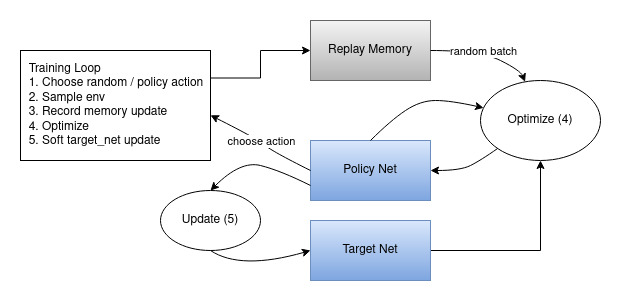


